# Module 3 Lab 1 - Univariate Time Series Analysis

In the last module we looked at some methods to apply to longitudinal data, where the data were generally partitioned in some way (by a patient group, treatment versus placebo, etc), and within each partition there was longitudinal data collected, usually with a small upper limit on the number of data points collected.

In this lab, we will look at univariate time series analysis, in which one variable is recorded at repeated time intervals.  Time series data is defined by the collection of data at regular intervals, such as every minute, hour, day, week, etc.  This is in contrast to some of the other data sets we have so far encountered, which have multiple data points collected across many subjects, which may have data recorded at irregular intervals, and/or where the intervals are not the same from subject to subject.

One of the most common examples you can find in the world for univariate time series is stock market data, where the price of a stock is tracked at a very high resolution, continuously.  Another domain where you see this kind of data is weather, such as the outside temperature at an airport as measured every hour.

In the health care space, epidemiological time series data is common, such as tracking incidences of flu, and in the medical space the outputs from an EEG are timeseries, as are the number of hospital admissions per day to the emergency department.  In this lab, we will approach how to analyze time series data, and break it down into its components to more fully understand the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
!{sys.executable} -m pip install --upgrade "statsmodels==0.11" # this step will take some time to complete

     |████████████████████████████████| 8.7MB 1.9MB/s eta 0:00:01
  Found existing installation: statsmodels 0.9.0
    Uninstalling statsmodels-0.9.0:
      Successfully uninstalled statsmodels-0.9.0


In [2]:
plt.rcParams["figure.figsize"] = [10, 5]

## Load the data

This dataset describes the daily total births for several years in a growing town.  There are two columns:
  * Date - the date for which births were recorded in the format YYYY-MM-DD
  * Births - the number of female births recorded for that date
  
We will be sure to mark the date column as such so Pandas will load it as a datetime type.

In [3]:
data = pd.read_csv('../resources/birth_data.csv', parse_dates=['Date'])

print(data.dtypes)
display(data)

Date      datetime64[ns]
Births             int64
dtype: object


,Date,Births
0,2010-01-01,6
1,2010-01-02,7
2,2010-01-03,6
3,2010-01-04,5
4,2010-01-05,8
...,...,...
1821,2014-12-27,14
1822,2014-12-28,37
1823,2014-12-29,32
1824,2014-12-30,40


## Plot the data

It is always useful to view a plot of the data.  We can start with the raw data as a line plot, and then look at yearly and seasonal trends with box plots.

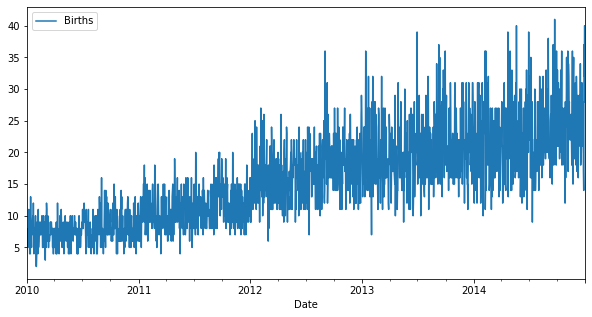

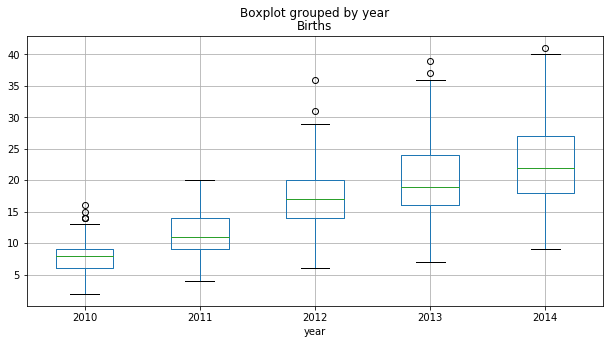

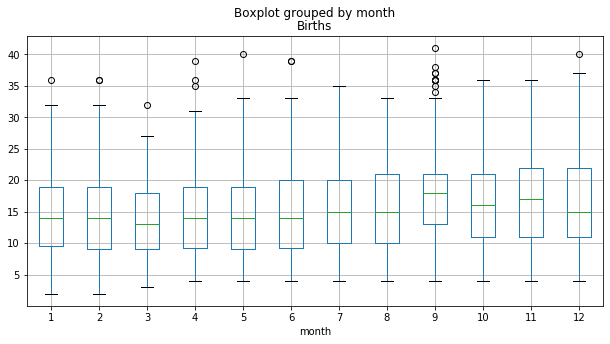

In [4]:
data.plot('Date', 'Births')

data['year'] = [d.year for d in data['Date']]
data['month'] = [int(d.strftime('%m')) for d in data['Date']]


data.boxplot('Births', 'year')
data.boxplot('Births', 'month')

## Patterns

We can spot that there is some underlying pattern by viewing these plots.  Births are increasing every year.  There may be a subtle rise and fall of births throughout the year.  These describe the basic components of a time series:

  * Trend - An increase or descresing slope in the time series
  * Seasonality or cylcic - if a pattern is repeated, then there is a cyclic or seasonal component
      * cyclic is not based on a calendar, but may have some other basis known or unknown
      * seasonal is a cyclic pattern that is tied to the 12 month calendar
  * Error, noise, residual - the component of a time series that is random after accounting for trend and cyclic
  
## Decomposition

It is possible to decompose a time series into these components, which we will do next.  We will use statsmodels to do the decomposition, using an implementation based on LOESS (locally estimated scatterplot smoothing):

https://www.statsmodels.org/v0.11.0/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL

We must set the date column as the index, and assign it a frequency. Possible frequencies are listed here:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [5]:
data = data.set_index('Date').asfreq('D') # set the index so statsmodels knows where the time component is, and make the frequency known as daily
data.sort_index(inplace=True) # ensure the values are sorted

Now make sure we don't have any missing values and run the decomposition.  When you assign a frequency to the index, missing values will get a row created for them, and will have values of Na for the dataframe columns.

**Note:** Using a datetime as the index with a set frequency is convenient when doing a time series analysis, but it's not required.  You can have a sequential integer as the index, but you will need to specify the `period` parameter in the STL decomposition because in cannot be discerned from an integer index.

In [6]:
display(data)
display(data[~np.isfinite(data['Births'])])


,Births,year,month
Date,,,
2010-01-01,6,2010,1
2010-01-02,7,2010,1
2010-01-03,6,2010,1
2010-01-04,5,2010,1
2010-01-05,8,2010,1
...,...,...,...
2014-12-27,14,2014,12
2014-12-28,37,2014,12
2014-12-29,32,2014,12


,Births,year,month
Date,,,


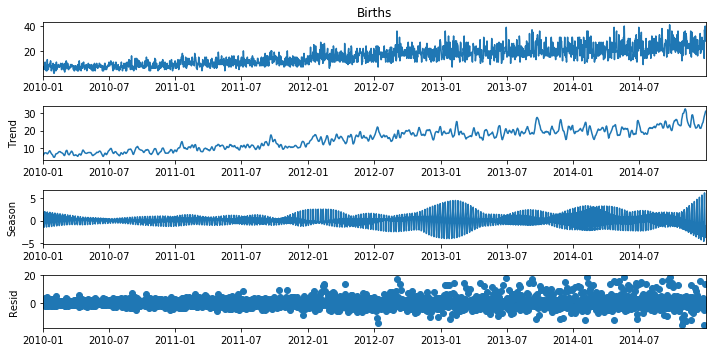

In [7]:
from statsmodels.tsa.seasonal import STL
decomp_result = STL(data['Births'], seasonal=31, robust=True).fit()
decomp_result.plot()
plt.show()

## Interpretation

We have chosen to smooth the seasonal component using a value of 31, approximately one month to try to see any monthly seasonality.  We also ran with `robust=True`, which will make the algorithm robust to outliers.

The trend that has been extracted clearly shows what we saw in the box plot by year, that births are increasing over time.  

There does not appear to be a regularly occurring seasonal component.

The residual plot shows that as time passes there is more uncertainty in the decomposition.

## Stationarity

Now that we've seen how to decompose a time series, we need to talk about a key property that will allow us to analyze a time series dataset.

A time series is considered stationary if the mean and variance do not change over time.  For our example data, because we have a trend that increases over time, we can be relatively certain that the data are non-stationary. We already know from the boxplots above that the mean increases each year.  But, rather than rely on plots to determine this, we will look to statistical tests.

Stationarity of a time series can be tested using various statistical tests.  Lets test our timeseries data using one such test, the Augmented Dickey Fuller test (ADF).

The Null hypothesis for the ADF test is that the time series has a unit root = 1, and the alternative is that the time series does not possess a unit root = 1.  A unit root is a mathematical property of a time series that indicates non-stationarity, and so is a fitting test for our purposes.

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Births'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.167743227042456
p-value: 0.687315620447302


Based on the p-value of ~0.69, we fail to reject the Null, and therefore conclude that this data is non-stationary.  Being non-stationary will introduce problems as we try to analyze the data further, so next we will learn how we might address that.

## Making a time series stationary
To make a time series stationary, we must remove the properties that make it non stationary.  For example, with our data, the mean changes over time, so to become non stationary, we need to transform the data such that the mean is constant over time.  One common method is to diff the series one or more times.  Taking a series difference is the process of subtracting the observation from time point k-1 from time point k.

Pandas has a built in method to do that for us, `diff()`.  We will take the diff, then plot that, and finally run the ADF test again (dropping na first, the first row in our dataset will be na due to not having a prior value to subutract)

,Births,year,month
Date,,,
2010-01-01,NaN,NaN,NaN
2010-01-02,1.0,0.0,0.0
2010-01-03,-1.0,0.0,0.0
2010-01-04,-1.0,0.0,0.0
2010-01-05,3.0,0.0,0.0


ADF Statistic: -16.04005483819294
p-value: 5.927538238360112e-29


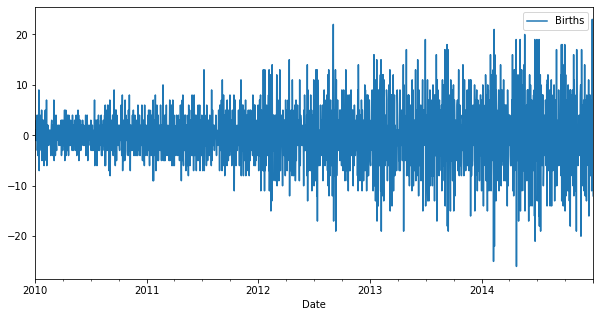

In [9]:
diff_data = data.diff()
display(diff_data.head())

diff_data.reset_index().plot('Date', 'Births')

result = adfuller(diff_data['Births'].dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Our p value is now small and so we can be reasonably assured that the first order difference of the time series is stationary.


## Manipulating the decomposition
One common thing we might want to do is to either work directly with the trend, or work with the seasonal component.  We can easily get those from the decomposition results.


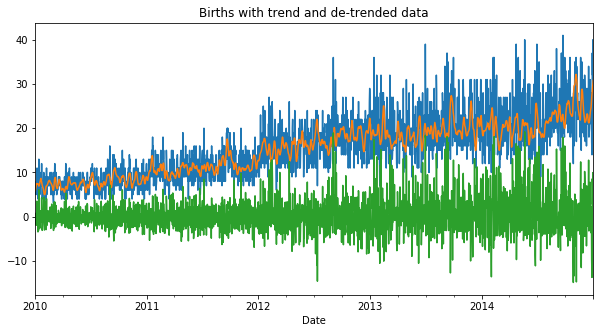

In [10]:
data['Births'].plot()

decomp_result.trend.plot()

(data['Births'] - decomp_result.trend).plot()
_ = plt.title('Births with trend and de-trended data')

## Autocorrelation
Autocorrelation of a timeseries occurs when the timeseries at a point in time k is a function of a prior point k-n, where n is the number of time steps in the past, otherwise known as the lag.

If there is not autocorrelation in the time series, then successive lag_plots of increasing lag will show less and less trend and more noise.

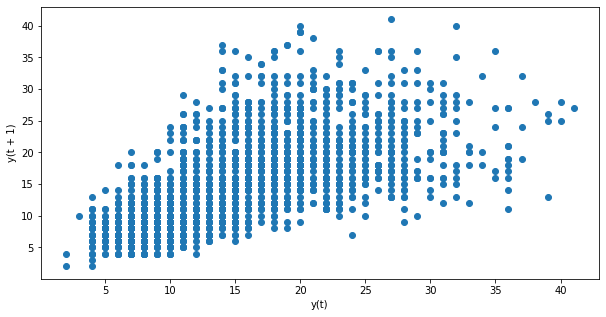

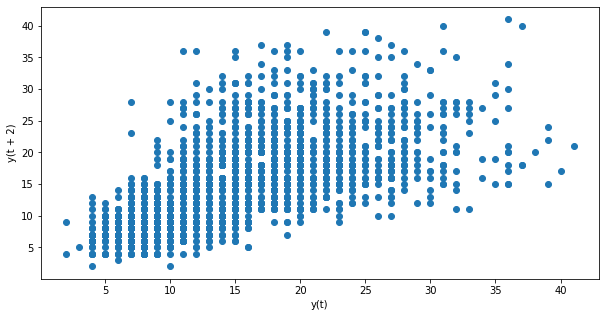

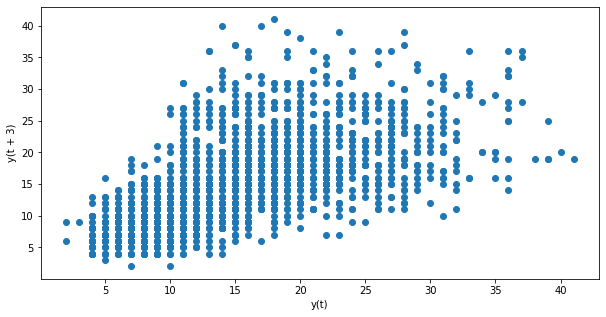

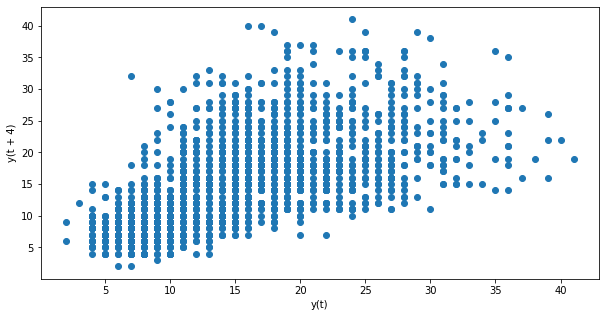

In [11]:
from pandas.plotting import lag_plot

lag_plot(data['Births'], lag=1)
plt.show()
lag_plot(data['Births'], lag=2)
plt.show()
lag_plot(data['Births'], lag=3)
plt.show()
lag_plot(data['Births'], lag=4)
plt.show()


In our data, the lag plots from lag 1 through 4 appear very similar and have some positive trend, therefore we have some evidence that the series may be autocorrelated.  This is positive news because it means that the next steps we take to form a predictive model around the time series are likely to be successful.

## Time series forecasting
Suppose we are planning a future hospital expansion and wish to determine whether the maternity ward requires additional beds.  One factor is such a decision would be knowing how many new births we might expect in future years.  Using our time series data on births, we will attempt to make such a model.

## Auto Regressive Integrated Moving Average (ARIMA) models
This class of models are dedicated to the task of creating forecasts using timeseries data.  They are based on the principle that prior data in the series can be used to predict future values.  They are fundamentally linear regression models, and this is the primary reason we were interested in making our time series stationary, to reduce or eliminate any self correlation.

To form an ARIMA model requires us to fit three parameters:

  * p - the order of the auto regression, i.e. how many lags behind the current value to use as predictors 
  * q - the order of the moving average, i.e. how many forecast error lags behind the current value to use as predictors
  * d - the number of differences to take to make the time series stationary
    
We've already seen how to take the diff of a time series and test for stationarity, but we want to choose the smallest lag that leads to stationary results, because over differencing a time series will cause unnecessary loss of data and therefore a worse model.

We will plot an auto correlation plot of the differences of our time series.  The objective is to find an autocorrelation plot that converges to zero fairly quickly, without over differencing unnecessarily.

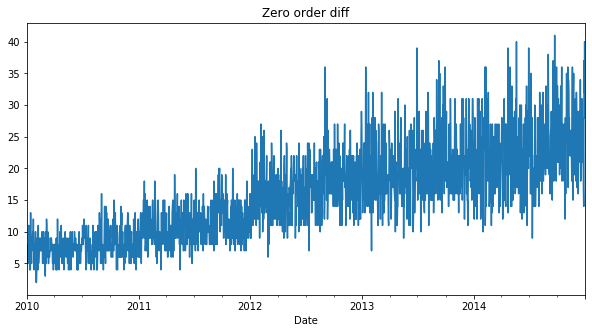

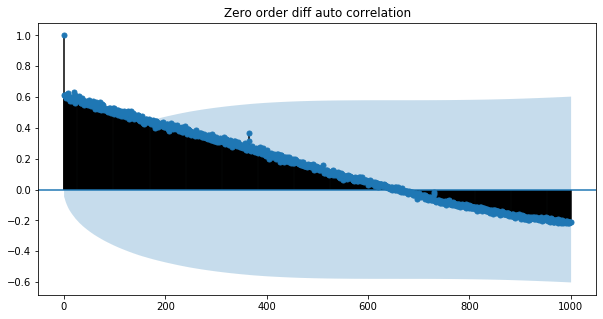

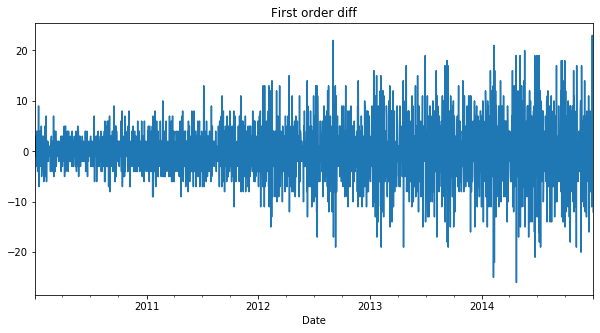

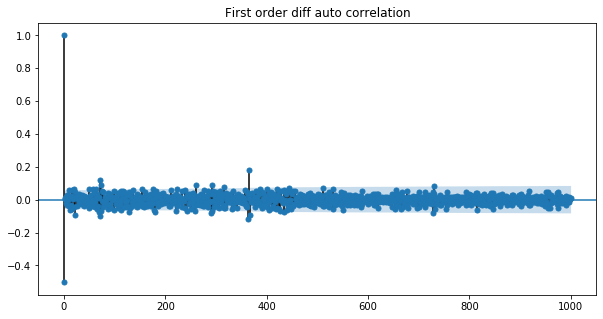

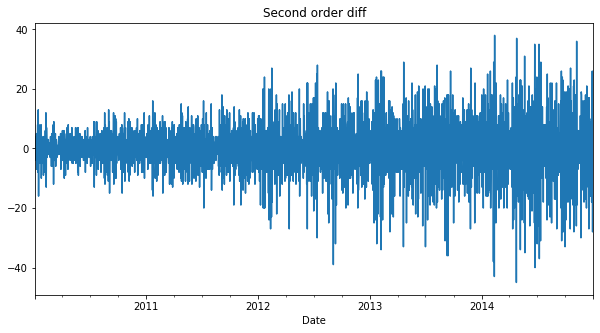

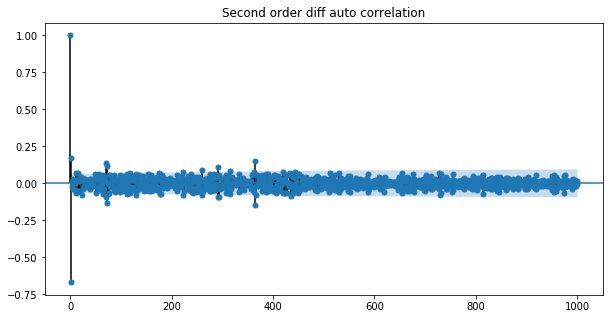

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

data['Births'].plot(title='Zero order diff')
plot_acf(data['Births'], title='Zero order diff auto correlation', lags=1000)
plt.show()

data['Births'].diff().dropna().plot(title='First order diff')
plot_acf(data['Births'].diff().dropna(), title='First order diff auto correlation', lags=1000)
plt.show()

data['Births'].diff().diff().dropna().plot(title='Second order diff')
plot_acf(data['Births'].diff().diff().dropna(), title='Second order diff auto correlation', lags=1000)
plt.show()

Based on these plots, a first order diff appears to approach zero correlation and a second order diff does not appear to cause the plot to converge faster.  We have also previously tested and found that the first order diff provided stationarity of the time series.  So a first order diff would be a good place to start for modeling as the `d` parameter.

## Finding the AR term

To find the AR term we look at the partial autocorrelation plot, pacf.  The pacf plot visualizes the partial autocorrelation along with a confidence interval.  We use the same order of diffs as it took to achieve stationarity.  

The number of lags that first crosses the confidence threshold is the initial value to use for the AR term.  In the below plot, we would choose 11, because the lag at point 11 is the first to cross the threshold (although it is very close at 9).  We are using the Yule-Walker method unadjusted for sample size (`method='ywm'`)to calculate the partial autocorrelation.  There are other methods available but this method suits our purpose fine.

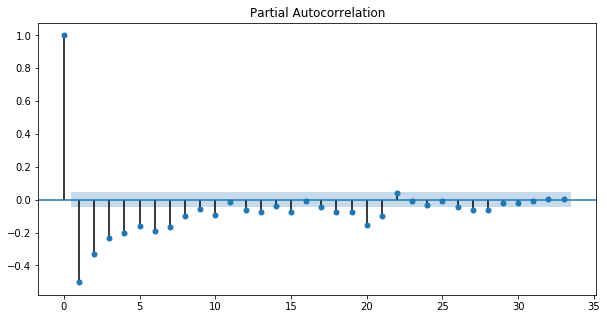

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['Births'].diff().dropna(),method='ywm')
plt.show()

## Finding the MA term

The moving average term can be found by examining the acf plot, similar to how we used the partial autocorrelation plot.  Use the same order of diffs as it took to achieve stationarity.  The first term to cross the confidence interval is at point 2, so that will be our MA term.

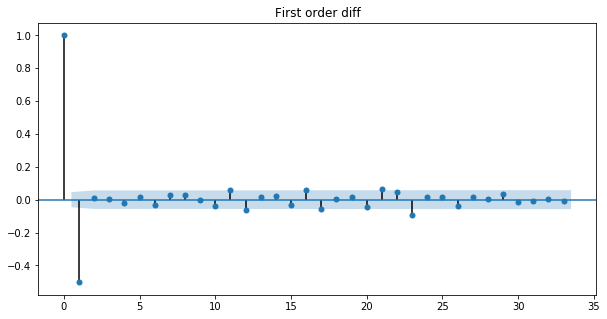

In [14]:
plot_acf(data['Births'].diff().dropna(), title='First order diff')
plt.show()

## Building the model

Now we will build the ARIMA model specifying the three terms we've estimated.  The documentation is here:

https://www.statsmodels.org/v0.11.0/generated/statsmodels.tsa.arima_model.ARIMA.html

We give our time series, and a tuple that contains or terms in (p,d,q) order.  Fitting the model will take some time.

In [15]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data['Births'], order=(11,1,2))
fit = model.fit()
print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                 1825
Model:                ARIMA(11, 1, 2)   Log Likelihood               -5355.189
Method:                       css-mle   S.D. of innovations              4.547
Date:                Mon, 31 Jan 2022   AIC                          10740.377
Time:                        10:58:33   BIC                          10823.017
Sample:                    01-02-2010   HQIC                         10770.861
                         - 12-31-2014                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0103      0.002      6.712      0.000       0.007       0.013
ar.L1.D.Births     -0.4529      0.250     -1.813      0.070      -0.943       0.037
ar.L2.D.Births      0.0268      

## Comparing predicted versus actual
We can compare a predicted plot from our model to the actual data.

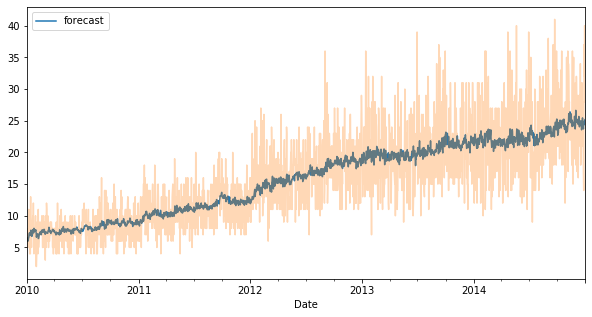

In [16]:
fig = fit.plot_predict(plot_insample=False)
data['Births'].plot(fig=fig, alpha=0.3)
plt.show()

## Plotting future predictions

We can plot the future predictions as well using the fitted model.

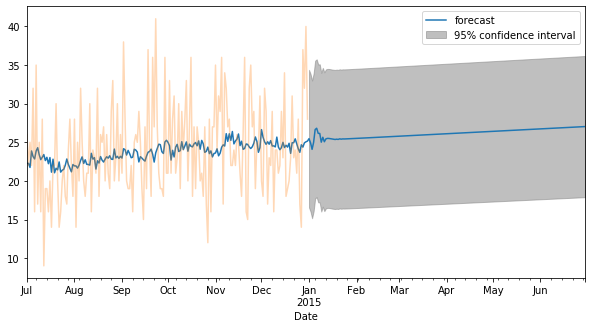

In [17]:
fig = fit.plot_predict(datetime(2014, 7, 1), datetime(2015,6,30), plot_insample=False)
data.loc[datetime(2014, 7, 1):]['Births'].plot(fig=fig, alpha=0.3)
plt.show()

## Improving the model
Note that in the model output above, many of the autoregressive coefficients were not significant.  Lets try to fit a model with a smaller number of AR and MA components and compare the models.

                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                 1825
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5365.186
Method:                       css-mle   S.D. of innovations              4.572
Date:                Mon, 31 Jan 2022   AIC                          10738.372
Time:                        11:35:26   BIC                          10760.410
Sample:                    01-02-2010   HQIC                         10746.501
                         - 12-31-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0102      0.002      4.926      0.000       0.006       0.014
ar.L1.D.Births     0.0080      0.024      0.330      0.742      -0.039       0.055
ma.L1.D.Births    -0.9814      0.006

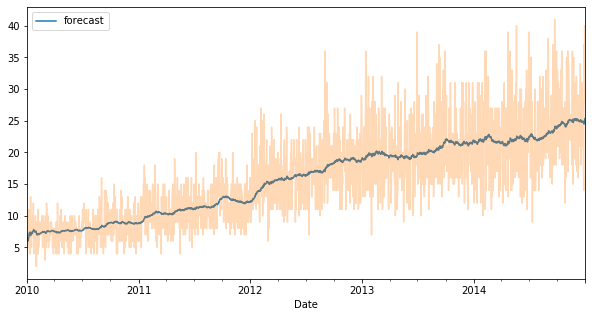

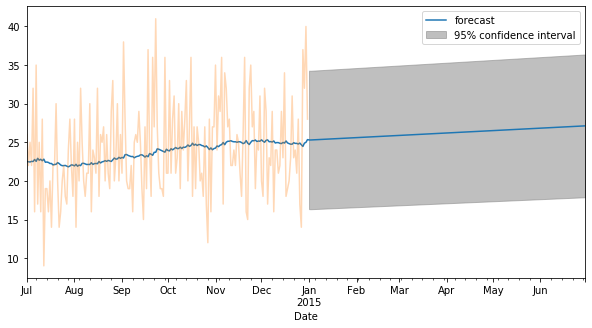

In [18]:
model = ARIMA(data['Births'], order=(1,1,1))
fit = model.fit()
print(fit.summary())

fig = fit.plot_predict(plot_insample=False)
data['Births'].plot(fig=fig, alpha=0.3)
plt.show()

fig = fit.plot_predict(datetime(2014, 7, 1), datetime(2015,6,30), plot_insample=False)
data.loc[datetime(2014, 7, 1):]['Births'].plot(fig=fig, alpha=0.3)
plt.show()

## Interpretation
Note that our AIC has gone down slightly indicating a better model, but the p values for the AR components are still high, indicating that using the lag values is not necessarily useful in predicting the future values.  This makes sense because our timeseries is highly variable from day to day, and it is difficult to capture that variability in any regression model.

We can build an ARIMA with no AR component and see what that looks like.

                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                 1825
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -5365.240
Method:                       css-mle   S.D. of innovations              4.572
Date:                Mon, 31 Jan 2022   AIC                          10736.481
Time:                        11:35:28   BIC                          10753.009
Sample:                    01-02-2010   HQIC                         10742.578
                         - 12-31-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0102      0.002      4.828      0.000       0.006       0.014
ma.L1.D.Births    -0.9808      0.006   -155.909      0.000      -0.993      -0.968
                                    

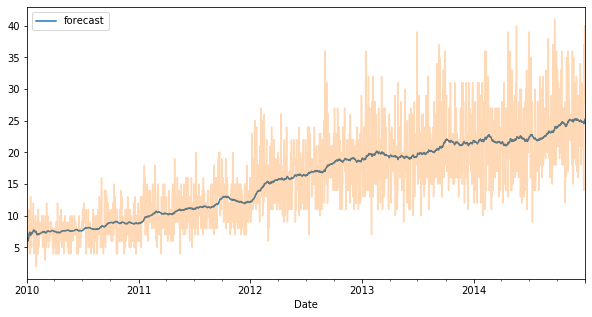

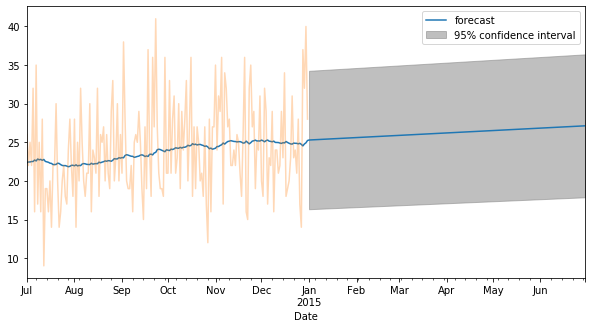

In [19]:
model = ARIMA(data['Births'], order=(0,1,1))
fit = model.fit()
print(fit.summary())

fig = fit.plot_predict(plot_insample=False)
data['Births'].plot(fig=fig, alpha=0.3)
plt.show()

fig = fit.plot_predict(datetime(2014, 7, 1), datetime(2015,6,30), plot_insample=False)
data.loc[datetime(2014, 7, 1):]['Births'].plot(fig=fig, alpha=0.3)
plt.show()

## Interpretation
We can see that the AIC has gone down again, and the predictions do not suffer with the loss of the AR component.


## Cross validation of model results
Lets examine a way to use cross validation to evaluate our model more fully.

First, we need to split our data into a train and test set.  We cannot do a random selection because we need to preserver order, so we simply make a slice in the data and save some for train and some for test.

We will use the first 67% of the data to train the model, and then test the predictions against the remaining 33%.

data length 1826
training data min, max: 2010-01-01 00:00:00 2013-05-07 00:00:00
testing data min, max:  2013-05-08 00:00:00 2014-12-31 00:00:00


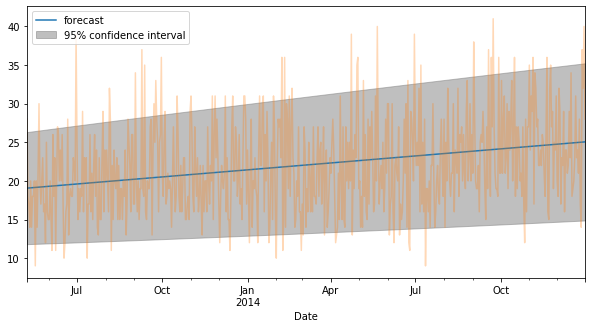

In [20]:
import math
print('data length', len(data))
cut_point = math.trunc(len(data)*0.67)
train = data[:cut_point]
test = data[cut_point:]

print('training data min, max:', train.index.min(), train.index.max())
print('testing data min, max: ', test.index.min(), test.index.max())

model = ARIMA(train['Births'], order=(0, 1, 1))  
fit = model.fit(disp=-1)  

fig = fit.plot_predict(test.index.min(), test.index.max(), plot_insample=False)
data.loc[test.index.min():]['Births'].plot(fig=fig, alpha=0.3)
plt.show()

## Accuracy metrics

To determine how well this model performs, we can look at the mean absolute percentage error (MAPE) and the correlation between the predicted and actual.  

The MAPE describes the average percent difference between the forcasted value and the actual value.  MAPE provides a value bounded at the bottom by zero and can be higher than 1 (indicating more than 100% difference between forecast and actual, which would be for a very poor model), and the correlation is between -1 and 1.  The closer to zero the better for MAPE, whereas a correlation close to one is better.

We make our sample predictions with the `forecast` method, specifying how many steps we want to forecast.  These steps are taken from the end of the training data sample.  We then compare to the first set of data from the testing dataset.

In [21]:
def mape(predicted, data):
    return np.mean(np.abs(predicted - data)/np.abs(data))

def corr(predicted, data):
    return np.corrcoef(predicted, data)[0,1] 

num_observations = len(test)
predicted, se, conf = fit.forecast(num_observations, alpha=0.05)

display(pd.DataFrame(np.vstack([test[:num_observations]['Births'], predicted])).T)

print('MAPE:   ', mape(predicted, test[:num_observations]['Births']))
print('Corr:   ', corr(predicted, test[:num_observations]['Births']))

,0,1
0,28.0,19.065134
1,18.0,19.075082
2,17.0,19.085030
3,14.0,19.094978
4,20.0,19.104925
...,...,...
598,14.0,25.013894
599,37.0,25.023842
600,32.0,25.033789
601,40.0,25.043737


MAPE:    0.24251521609653617
Corr:    0.260529121354235


## Interpretation
The MAPE is 0.243, so on average the predictions were off by 24.3%.  The correlation between the predicted and actual values is not very high, which likely indicates that the data has a high variance.

## SARIMA - Seasonal ARIMA
In this lab, we analyzed a timeseries dataset that did not have a seasonal component.  There are many types of data that do have seasonal components, such as incidences of seasonal diseases like influenza.  SARIMA is an approach that handles the trend and seasonality of a timeseries in one model.  You specify the same p,d,q parameters for the trend component, but additionally you also must specify P,D,Q for the seasonal component.  The meanings of these parameters are similar to that for the trend component.  statsmodels has a SARIMA model fitter, documented here: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In this course, due to time constraints, we will not cover SARIMA in detail.  You can still create a model on timeseries data with a seasonal component by performing decomposition and running an ARIMA model on the data minus the seasonal component data that was extracted.  In the exercise for this module you will perform such an operation.